# NN back propagation（神经网络反向传播）

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
def load_data(path):
    
    data = sio.loadmat(path)#加载MATLAB文件,返回的是以各个变量名为key，数组为values的字典
    print(data)
    
    #事实上，图像在martix X中表示为400维向量（其中有5,000个）。400维“特征”是在原始20 x 20共400个像素点中，每个像素的灰度强度。
    #类标签则被保存在向量y中，作为表示图像中数字的数字类。
    
    X = data.get('X')  # 查看data情况后，从字典中取出key=X的项的value值，存入X中，其实就是(5000,400)的二维列表

    y = data.get('y')  # 查看data情况后，从字典中取出key=y的项的value值，存入y中，其实就是(5000,1)的列表
    
    y = y.reshape(y.shape[0])  # 将其转换为列向量

    return X, y

In [3]:
X, _ = load_data('ex4data1.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}


In [4]:
def plot_100_image(X):#用来根据100个样本的400*100条数据绘制100个图片

    size = int(np.sqrt(X.shape[1]))#sqrt用来给括号内元素开方的，X=(5000, 400)，因此size=20，这是用来确定图片尺寸的

    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # #从第0-5000个样本中随机选择100个样本,存入列表sample_idx
    
    sample_images = X[sample_idx, :]#取出那100个样本所在的行的一整行数据，共400个，存入sample_images中，sample_images=100*400

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(8, 8))
    #nrows,ncols表示子图网的行数与列数；sharex，sharey表示所有10*10=100个子图都共享一个x轴、一个y轴；figsize表示图片尺寸为8*8

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
    #绘制100个子图，r表示绘制在第r行，c表示第c列，第r行第c列的数据在数组中就是第10 * r + c组[400]数据
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            # 将坐标轴x和y的刻度都设置为空，也就是不设置xy刻度，只画图

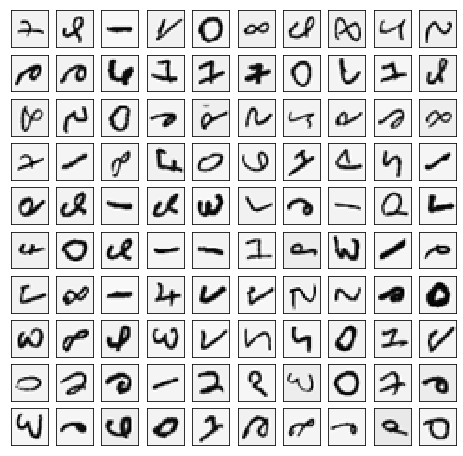

In [5]:
plot_100_image(X)

plt.show()

# 神经网络部分

In [6]:
#重新读取一遍数据，返回特征X与标签y
X_raw, y_raw = load_data('ex4data1.mat')
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)#在400个特征前面插入一列全1数据，也就是用来表示x0的
print(X_raw.shape)
print(y_raw.shape)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}
(5000, 400)
(5000,)


In [7]:
print(y_raw)#查看y_raw

np.unique(y_raw)#查看有几类标签，也就是y_raw的取值有几种

[10 10 10 ...  9  9  9]


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [8]:
#将每个1维标签数据都变为10维数据，最终得到（5000,10）的标签矩阵
def expand_y(y_raw):

    res = []
    
    for i in y_raw:#遍历标签列表y_raw中的5000个样本的标签值
        
        y_array = np.zeros(10)#为每个标签值都生成一个新的、10维的全0列表
        
        y_array[i - 1] = 1
        #如果标签值为1，就把这个10维列表的第0个位置上的元素改为1，其他位置仍为0；
        #如果标签值为2，就把这个10维列表的第1个位置上的元素改为1，其他位置仍为0;
        #...如果标签值为10，就把这个10维列表的第9个位置上的元素改为1，其他位置仍为0;

        res.append(y_array)

    return np.array(res)
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse=False)
# y_onehot = encoder.fit_transform(y)
# y_onehot.shape #这个函数与expand_y(y)一致

In [9]:
y = expand_y(y_raw)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# 读取权重数据
在这个nn架构中，我们有权重theta1（25,401），theta2（10,26），而它们的梯度是delta1，delta2

In [10]:
def load_weight(path):
    
    data = sio.loadmat(path)
    
    return data['Theta1'], data['Theta2']
#Theta1是神经网络中第1层（输入层）到第2层（隐藏层）的权重矩阵，Theta2是神经网络中第2层（隐藏层）到第3层（输出层）的权重矩阵
#theta_j的维度为（j+1层中的单位数量）*（j层中的单位数量+1），因此各层中隐藏单元数量为400-25-10

In [11]:
t1, t2 = load_weight('ex4weights.mat')

t1.shape, t2.shape

((25, 401), (10, 26))

In [12]:
def serialize(a, b):#此方法可以将矩阵a，b扁平化为一维数组后拼接在一起（此操作可复原，方便处理）
  
    return np.concatenate((np.ravel(a), np.ravel(b)))

In [13]:
def deserialize(theta):#此方法可以将上面扁平化的参数恢复原状，变回（25，401），（10，26）的两个矩阵
    
    return theta[:25 * 401].reshape(25, 401), theta[25 * 401:].reshape(10, 26)

In [14]:
theta = serialize(t1, t2)  # 将两个权重矩阵扁平化后拼接在一起，方便后续使用，长度为25*401+10*26=10285
theta.shape

(10285,)

# feed forward（前向传播）
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: left;" src="../img/nn_model.png">

In [15]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))

In [16]:
#前向传播算法
def feed_forward(theta, X):

    t1, t2 = deserialize(theta)  #将扁平化的参数恢复原状，得到两层的参数矩阵，t1: (25,401) t2: (10,26)
    m = X.shape[0] #得到样本数量，5000
    a1 = X  # 第1层的神经元们，其实就是输入层内输入的数据矩阵，共5000条数据，每条都分成401个特征输入，（5000,401）

    z2 = a1 @ t1.T  # (5000, 401) @ (25,401).T = (5000, 25)
    
    a2 = sigmoid(np.insert(z2, 0, np.ones(m), axis=1))  # 在z2的各特征前面添加一列偏置项后，再将sigmoid函数逐个作用于所有元素，生成a2，也就是第2层的神经元们，5000*26

    z3 = a2 @ t2.T  # 5000 * 10
    h = sigmoid(z3)  # 5000*10, this is h_theta(X)

    return a1, z2, a2, z3, h  
# 这些变量都需要保留，在反向传播中使用，其中h是最终的5000*10的判断结果，5000个样本，对每个样本都判断其取值为0、为1...为9的概率


In [17]:
_, _, _, _, h = feed_forward(theta, X)
h # 5000*10

array([[1.38245045e-04, 2.05540079e-03, 3.04012453e-03, ...,
        4.91017499e-04, 7.74325818e-03, 9.96229459e-01],
       [5.87756717e-04, 2.85026516e-03, 4.14687943e-03, ...,
        2.92311247e-03, 2.35616705e-03, 9.96196668e-01],
       [1.08683616e-04, 3.82659802e-03, 3.05855129e-02, ...,
        7.51453949e-02, 6.57039547e-03, 9.35862781e-01],
       ...,
       [6.27824726e-02, 4.50406476e-03, 3.54510925e-02, ...,
        2.63669734e-03, 6.89448164e-01, 2.74369466e-05],
       [1.01908736e-03, 7.34360211e-04, 3.78558700e-04, ...,
        1.45616578e-02, 9.75989758e-01, 2.33374461e-04],
       [5.90807037e-05, 5.41717668e-04, 2.58968308e-05, ...,
        7.00508308e-03, 7.32814653e-01, 9.16696059e-02]])

# 不考虑正则化时的代价函数
<img style="float: left;" src="../img/nn_cost.png">

In [18]:
def cost(theta, X, y):#返回正则化损失函数值J（θ）的前半部分，也就是不考虑正则化时的J（θ）

    m = X.shape[0]  # 得到样本数量m=5000

    _, _, _, _, h = feed_forward(theta, X) #h是最终的5000*10的判断结果，5000个样本，对每个样本都判断其取值为0、为1...为9的概率，相当于输出单元数量10

    pair_computation = -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))# multiply负责将数组和矩阵的对应位置相乘，输出与相乘数组/矩阵的大小一致

    return pair_computation.sum() / m

# 考虑正则化后的代价函数
<img style="float: left;" src="../img/nn_regcost.png">

In [19]:
#计算正则化损失函数𝐽(𝜃)，函数值为cost中记录的、不考虑正则化时的前半部分，再加上每一层的正则项（此处共两层，即隐藏层和输出层）
def regularized_cost(theta, X, y, l=1):
    
    t1, t2 = deserialize(theta)  # #将扁平化的参数恢复原状，得到两层的参数矩阵，t1: (25,401) t2: (10,26)
    
    m = X.shape[0]# 得到样本数量m=5000

    reg_t1 = (l / (2 * m)) * np.power(t1[:, 1:], 2).sum()  #在正则化中不惩罚常数项，即不惩罚theta0，此处计算的是隐藏层的正则项
    
    reg_t2 = (l / (2 * m)) * np.power(t2[:, 1:], 2).sum()  #此处计算的是输出层的正则项

    return cost(theta, X, y) + reg_t1 + reg_t2
#正则化损失函数=原损失函数+隐藏层的正则项+输出层的正则项


In [20]:
regularized_cost(theta, X, y)#计算整个神经网络的正则化损失函数𝐽(𝜃)

0.3872849740890859

# 反向传播

读取数据和权重的过程与前向传播相同

In [21]:
X.shape,y.shape

((5000, 401), (5000, 10))

In [22]:
t1.shape, t2.shape

((25, 401), (10, 26))

In [23]:
theta.shape

(10285,)

In [24]:
def sigmoid_gradient(z):  

    return np.multiply(sigmoid(z), 1 - sigmoid(z))# multiply负责将数组和矩阵的对应位置相乘，输出与相乘数组/矩阵的大小一致

# 在求各项真正的偏导数D前先计算△矩阵

In [25]:
def gradient(theta, X, y):#在求各项真正的偏导数D前先计算△矩阵
# 在这个nn架构中，我们有theta1（25,401），theta2（10,26），它们的梯度是delta1，delta2 

    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]# 得到样本数量m=5000

    delta1 = np.zeros(t1.shape)  # 初始化隐藏层的梯度delta1为全0矩阵，维度为(25, 401)
    delta2 = np.zeros(t2.shape)  # 初始化输出层的梯度delta2为全0矩阵，维度为(10, 26)

    a1, z2, a2, z3, h = feed_forward(theta, X)
    # a1为第1层的神经元们，其实就是输入层内输入的数据矩阵，共5000条数据，每条都分成401个特征输入，（5000,401）
    #z2为a1@t1.T，(5000, 25)
    #a2在z2的各特征前面添加一列偏置项，再将sigmoid函数逐个作用于z2中的所有元素，生成第2层的神经元们，（5000*26）
    #z3为a2@t2.T，（5000 * 10）
    #h将sigmoid函数逐个作用于z3中的所有元素，生成输出层的神经元们，（5000*10）
    #h也是最终的5000*10的判断结果，5000个样本，对每个样本都判断其取值为0、为1...为9的概率
    

    for i in range(m):
        hi = h[i, :]    # 取最终预测结果h的第i行的所有列数据，变为(1, 10)的一维列表
        yi = y[i, :]    # (1, 10)
        d3i = hi - yi  # 两者直接相减，查看第3层的输出结果与应有结果之间的偏差，(1, 10)
        
        z2i = z2[i, :]  # (1, 25)
        z2i = np.insert(z2i, 0, np.ones(1))  # 在z2i前面插一个1，作为偏置项，这是为了将其从（1,25）变为（1,26），与a2i格式对齐
        a2i = a2[i, :]  # (1, 26)
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i))  # 两者按公式相计算，查看第2层的输出结果与应有结果之间的偏差，(1, 26)
        
        a1i = a1[i, :]  # (1, 401)
        
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # 将这5000个样本中，每一次计算得到的输出层的梯度delta2累加，(1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # 将这5000个样本中，每一次计算得到的隐藏层的梯度delta1累加，(1, 25).T @ (1, 401) -> (25, 401)

    return serialize(delta1, delta2)#扁平化参数

In [26]:
d1, d2 = deserialize(gradient(theta, X, y))#将gradient中得到的扁平化参数恢复原样

In [27]:
d1.shape, d2.shape

((25, 401), (10, 26))

# 根据△矩阵计算各项真正的偏导数

<img style="float: left;" src="../img/nn_reg_grad.png">

In [28]:
#根据△矩阵计算各项真正的偏导数
def regularized_gradient(theta, X, y, l=1):
    
    m = X.shape[0]# 得到样本数量m=5000

    delta1, delta2 = deserialize(gradient(theta, X, y))#两层的△矩阵
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    t1, t2 = deserialize(theta)#2层的各个特征的权重矩阵

    t1[:, 0] = 0 #将第一层第0项的权重，也就是偏置项的权重先设为0，因为训练模型时不惩罚偏置项
    reg_term_d1 = (l / m) * t1
    delta1 = delta1 + reg_term_d1

    t2[:, 0] = 0
    reg_term_d2 = (l / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)#扁平化参数

# 准备训练模型

In [29]:
def random_init(size):
    
    return np.random.uniform(-0.12, 0.12, size)#初始化权重矩阵，从（-0.12, 0.12）中随机采取size个样本，因为在神经网络中，参数theta的初始值不能全设为0

In [30]:
def nn_training(X, y):

    init_theta = random_init(10285)  # 将权重theta随机初始化为长度为10285的一维数组，10285=25*401 + 10*26，在后面的操作中会将其转换为两个应有的二维矩阵格式的

    res = opt.minimize(fun=regularized_cost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    #为了让目标函数，也就是损失函数regularized_cost最小化，根据梯度函数，也就是偏导函数regularized_gradient，训练权重矩阵，init_theta
    #以上函数原本都是两个二维数组，但在输入输出时都被扁平化处理成了一维数组，只有函数内部是当作两个二维数组来处理的
    return res

In [31]:
res = nn_training(X, y)#慢
res

     fun: 0.32609356012076507
     jac: array([-1.54302978e-04,  4.60727146e-08,  1.73561366e-07, ...,
        8.22634196e-05,  9.93066826e-05,  8.48020083e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 25
  status: 3
 success: False
       x: array([ 0.00000000e+00,  2.30363573e-04,  8.67806832e-04, ...,
       -2.24268123e-01,  1.37663344e+00, -5.78790703e-01])

# 显示准确率

In [32]:
_, y_answer = load_data('ex4data1.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}


In [33]:
final_theta = res.x

In [34]:
_, _, _, _, h = feed_forward(final_theta, X)#用训练好的模型的权重theta重新执行一遍前向传播函数，得到最终的预测值

y_pred = np.argmax(h, axis=1) + 1#按行观察输出层h的每一行数据，取出在本行中的值最大数所在的索引位置（其实就是取出将样本取值预测为0-10时，概率最高的那个数，将其作为最终的预测值）
#在numpy中，0是基本索引，而matlab中，基本索引要+1

correct = [1 if a == b else 0 for (a, b) in zip(y_pred,y_answer)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 94.6%


In [35]:
print(classification_report(y_pred,y_answer))

              precision    recall  f1-score   support

           1       0.96      1.00      0.98       482
           2       0.99      0.96      0.97       515
           3       0.98      0.93      0.95       530
           4       1.00      0.89      0.94       560
           5       0.72      1.00      0.84       361
           6       1.00      0.97      0.98       513
           7       0.96      0.98      0.97       489
           8       1.00      0.84      0.91       596
           9       0.86      1.00      0.92       430
          10       1.00      0.95      0.97       524

   micro avg       0.95      0.95      0.95      5000
   macro avg       0.95      0.95      0.94      5000
weighted avg       0.96      0.95      0.95      5000



# 显示隐藏层

In [36]:
def plot_hidden_layer(theta):#theta为长度10285的一维数组

    final_theta1, _ = deserialize(theta)#将扁平化的参数theta恢复原状，放回（25，401），（10，26）的ndarray，final_theta1即为隐藏层的参数
    
    hidden_layer = final_theta1[:, 1:]  # 只取除偏置项theta0以外的其他列的参数

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
    #绘制25个子图，r表示绘制在第r行，c表示第c列，第r行第c列的数据在数组中就是第5 * r + c组[400]数据，将其转化为（20，20）的二维矩阵后绘制
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            # 将坐标轴x和y的刻度都设置为空，也就是不设置xy刻度，只画图

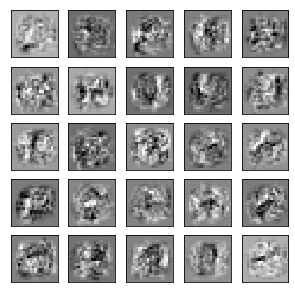

In [37]:
plot_hidden_layer(final_theta)
plt.show()